# Project in two dimensions

In [1]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [2]:
# hard-code the paths of our input and output directories
path_input = "../data/input"
path_output = "../data/output"

# check input images are loaded
stack.check_input_data(path_input)

experiment_1_dapi_fov_1.tif is already in the directory
experiment_1_smfish_fov_1.tif is already in the directory


In this notebook, we show examples of **image projection** and different methods to manage the **out-of-focus z-slices**. We use 3D images. **Several cells of this notebook take few minutes to run !!!**

In [3]:
path = os.path.join(path_input, "experiment_1_dapi_fov_1.tif")
nuc = stack.read_image(path)
print("dapi channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype), "\n")

path = os.path.join(path_input, "experiment_1_smfish_fov_1.tif")
rna = stack.read_image(path)
print("dapi channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

dapi channel
 shape: (23, 650, 500)
 dtype: uint16 

dapi channel
 shape: (23, 650, 500)
 dtype: uint16


## Basic 2D projections

**Basic projection algorithms** evolve simple methods, computing the maximum, average or median value along the z-axis. The **Maximum Intensity Projection (MIP)** is often robust and clear enough to analyze the image.

In [4]:
nuc_max = stack.maximum_projection(nuc)
nuc_mean = stack.mean_projection(nuc, return_float=False)
nuc_median = stack.median_projection(nuc)

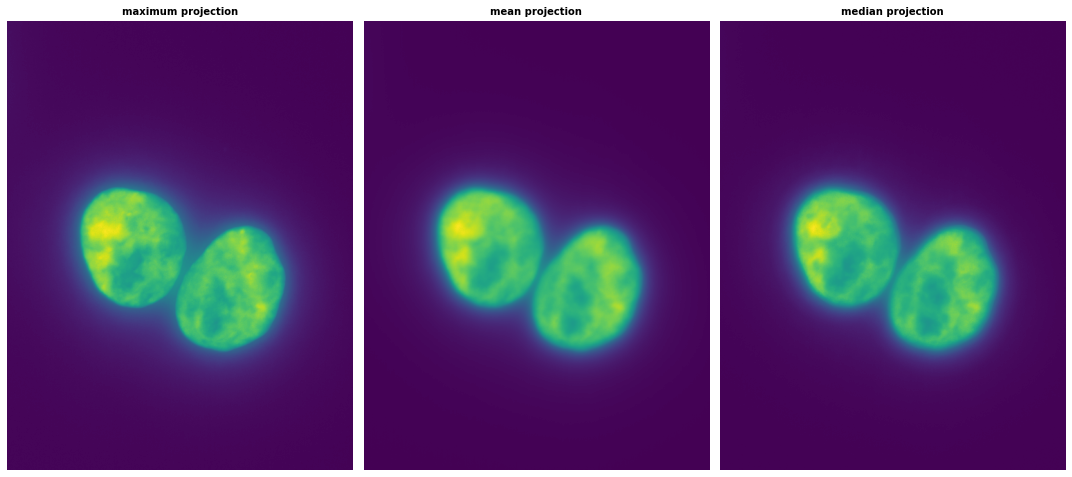

In [5]:
images = [nuc_max, nuc_mean, nuc_median]
titles = ["maximum projection", "mean projection", "median projection"]
plot.plot_images(images, rescale=True, titles=titles)

__Note:__ If some z-slices are completely out-of-focus, it can degrade the projection. Be able to remove these z-slices before projecting or apply a more subtil projection algorithm can help.

## In-focus and out-of-focus z-slices

First, we can blur the last z-slices of our image to illustrate problems that arise with out-of-focus images.

In [6]:
# RNA
rna_mip = stack.maximum_projection(rna)

# blurred RNA (we simulate some z-slices out-of-focus)
rna_blurred = rna.copy()
rna_blurred[-4:, ...] = stack.gaussian_filter(rna_blurred[-4:, ...], sigma=5) * 1.5
rna_blurred_mip = stack.maximum_projection(rna_blurred)

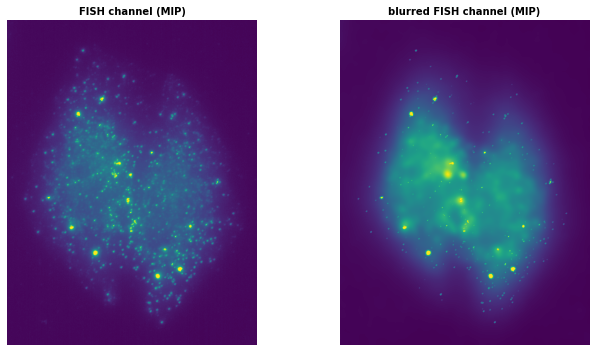

In [7]:
images = [rna_mip, rna_blurred_mip]
titles = ["FISH channel (MIP)", "blurred FISH channel (MIP)"]
plot.plot_images(images, titles=titles, framesize=(10, 5), contrast=True)

### Measure image sharpness

We can measure a **sharpness score** for each z-slice and compare our original image with its blurred version. As expected, the score drops for the last z-slices we blur.

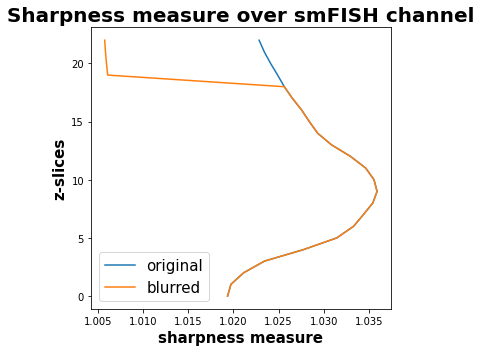

In [8]:
focus = stack.compute_focus(rna, neighborhood_size=31)
focus_blurred = stack.compute_focus(rna_blurred, neighborhood_size=31)
measures = [focus.mean(axis=(1, 2)), focus_blurred.mean(axis=(1, 2))]
plot.plot_sharpness(measures, labels=["original", "blurred"], 
                    title="Sharpness measure over smFISH channel")

Such sharpness measure can be used to remove the out-of-focus z-slices before projecting. We remove the 4 most out-of_focus images. In the original image, we remove the first 3 z-slices and the last one. In the blurred image, we remove the 4 last z-slices.

In [9]:
nb_to_keep = rna.shape[0] - 4
z_indices_to_keep = stack.get_in_focus_indices(focus, proportion=nb_to_keep)
print("In-focus z-slices in the original image:", z_indices_to_keep)
z_indices_to_keep_blurred = stack.get_in_focus_indices(focus_blurred, proportion=nb_to_keep)
print("In-focus z-slices in the blurred image:", z_indices_to_keep_blurred)

In-focus z-slices in the original image: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
In-focus z-slices in the blurred image: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


Using `bigfish.stack.in_focus_selection` we directly **remove the out-of-focus z-slices** from our image. This should not be used for 3D analysis or transformation (for example a 3D spot detection), as the space between consecutive z-slices would not be consistent anymore. Such cleaning is still usefull before a 2D projection.  

In [10]:
# RNA
in_focus_image = stack.in_focus_selection(rna, focus, proportion=nb_to_keep)
in_focus_image_mip = stack.maximum_projection(in_focus_image)

# blurred RNA
in_focus_image_blurred = stack.in_focus_selection(rna_blurred, focus_blurred, proportion=nb_to_keep)
in_focus_image_blurred_mip = stack.maximum_projection(in_focus_image_blurred)

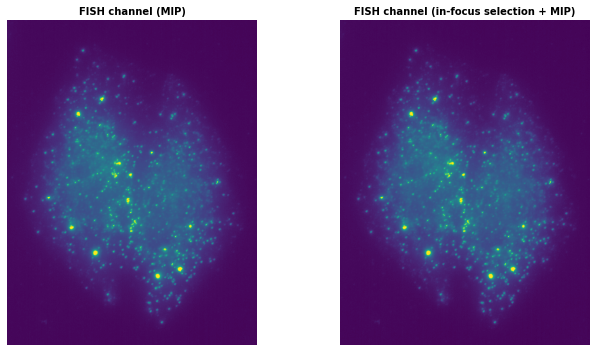

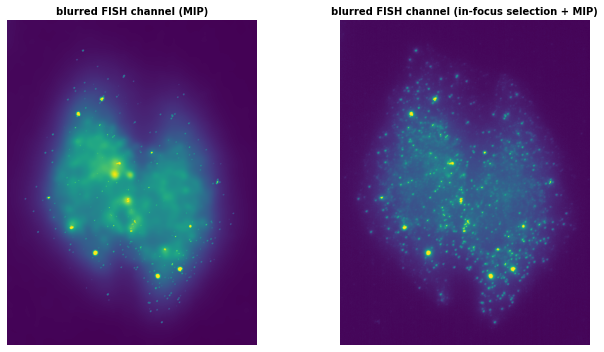

In [11]:
# RNA
images = [rna_mip, in_focus_image_mip]
titles = ["FISH channel (MIP)", "FISH channel (in-focus selection + MIP)"]
plot.plot_images(images, titles=titles, framesize=(10, 5), contrast=True)

# blurred RNA
images = [rna_blurred_mip, in_focus_image_blurred_mip]
titles = ["blurred FISH channel (MIP)", "blurred FISH channel (in-focus selection + MIP)"]
plot.plot_images(images, titles=titles, framesize=(10, 5), contrast=True)

### Focus projection

Another way to deal with out-of-focus z-slices is `bigfish.stack.focus_projection`. We only project the *zyx* voxels with the highest sharpness score.

In [12]:
# RNA
rna_focus = stack.focus_projection(rna, proportion=0.75, neighborhood_size=7, method="median")

# blurred RNA
rna_blurred_focus = stack.focus_projection(rna_blurred, proportion=0.75, neighborhood_size=7, method="median")

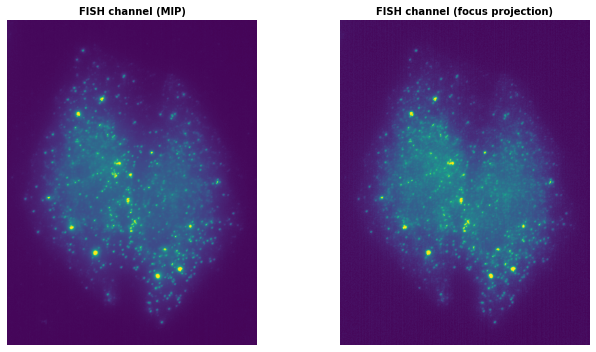

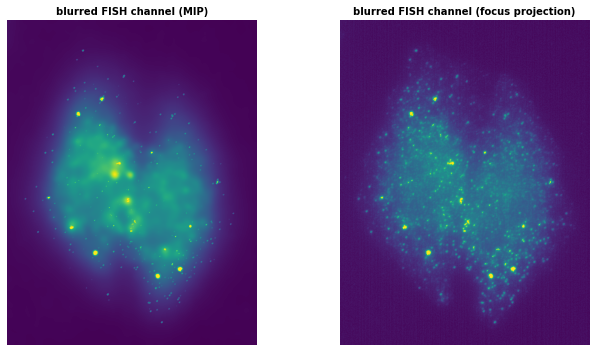

In [13]:
# RNA
images = [rna_mip, rna_focus]
titles = ["FISH channel (MIP)", "FISH channel (focus projection)"]
plot.plot_images(images, titles=titles, framesize=(10, 5), contrast=True)

# blurred RNA
images = [rna_blurred_mip, rna_blurred_focus]
titles = ["blurred FISH channel (MIP)", "blurred FISH channel (focus projection)"]
plot.plot_images(images, titles=titles, framesize=(10, 5), contrast=True)